In [1]:
# ----------------------------- 라이브러리 임포트 -----------------------------
import os
import numpy as np
import torch
import torch.nn as nn
import librosa
import librosa.display
import matplotlib.pyplot as plt
import re
from typing import Tuple

from matplotlib import font_manager
from torchsummary import summary  # 모델 요약을 위한 라이브러리
from torchviz import make_dot       # 모델 그래프 시각화를 위한 라이브러리
import seaborn as sns

# 시스템 내 설치된 폰트 확인 (macOS 기준)
font_manager.findSystemFonts()

# 한글 폰트 설정 (macOS 기준, Windows나 Linux는 폰트 경로를 변경해야 할 수 있음)
font_location = "/System/Library/Fonts/AppleSDGothicNeo.ttc"
font_name = font_manager.FontProperties(fname=font_location).get_name()
plt.rc('font', family=font_name)


In [2]:
# ----------------------------- 모델 정의 -----------------------------
class CNNModel(nn.Module):
    """
    CNN 모델 정의 클래스
    """

    def __init__(
        self,
        input_shape: Tuple[int, int, int],
        num_classes: int,
        dropout_rate: float = 0.5,
        l2_reg: float = 0.001,
    ):
        """
        모델을 초기화합니다.

        Args:
            input_shape (Tuple[int, int, int]): 입력 데이터의 형태.
            num_classes (int): 출력 클래스의 수.
            dropout_rate (float): 드롭아웃 비율.
            l2_reg (float): L2 정규화 계수.
        """
        super(CNNModel, self).__init__()
        self.conv1 = nn.Conv2d(1, 128, kernel_size=(3, 3), padding="same")
        self.pool1 = nn.MaxPool2d((2, 2))
        self.bn1 = nn.BatchNorm2d(128)

        self.conv2 = nn.Conv2d(128, 64, kernel_size=(3, 3), padding="same")
        self.pool2 = nn.MaxPool2d((2, 2))
        self.bn2 = nn.BatchNorm2d(64)

        self.conv3 = nn.Conv2d(64, 32, kernel_size=(3, 3), padding="same")
        self.pool3 = nn.MaxPool2d((2, 2))
        self.bn3 = nn.BatchNorm2d(32)

        conv_output_size = self._get_conv_output(input_shape)

        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(conv_output_size, 256)
        self.dropout1 = nn.Dropout(dropout_rate)
        self.fc2 = nn.Linear(256, 128)
        self.dropout2 = nn.Dropout(dropout_rate)
        self.fc3 = nn.Linear(128, 64)
        self.dropout3 = nn.Dropout(dropout_rate)
        self.output_layer = nn.Linear(64, num_classes)
        self.l2_reg = l2_reg

    def _get_conv_output(self, shape: Tuple[int, int, int]) -> int:
        """
        합성곱 계층의 출력을 계산합니다.

        Args:
            shape (Tuple[int, int, int]): 입력 데이터의 형태.

        Returns:
            int: 합성곱 계층 출력의 크기.
        """
        bs = 1
        input = torch.zeros(bs, *shape)
        output_feat = self._forward_features(input)
        n_size = output_feat.data.view(bs, -1).size(1)
        return n_size

    def _forward_features(self, x: torch.Tensor) -> torch.Tensor:
        """
        합성곱 계층을 통과하는 부분입니다.

        Args:
            x (torch.Tensor): 입력 텐서.

        Returns:
            torch.Tensor: 합성곱 계층의 출력.
        """
        x = self.conv1(x)
        x = torch.relu(x)
        x = self.pool1(x)
        x = self.bn1(x)

        x = self.conv2(x)
        x = torch.relu(x)
        x = self.pool2(x)
        x = self.bn2(x)

        x = self.conv3(x)
        x = torch.relu(x)
        x = self.pool3(x)
        x = self.bn3(x)
        return x

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        """
        모델의 순전파를 정의합니다.

        Args:
            x (torch.Tensor): 입력 텐서.

        Returns:
            torch.Tensor: 모델의 출력.
        """
        x = self._forward_features(x)
        x = x.view(x.size(0), -1)  # Flatten
        x = self.fc1(x)
        x = torch.relu(x)
        x = self.dropout1(x)
        x = self.fc2(x)
        x = torch.relu(x)
        x = self.dropout2(x)
        x = self.fc3(x)
        x = torch.relu(x)
        x = self.dropout3(x)
        x = self.output_layer(x)
        x = torch.sigmoid(x)
        return x

    def l2_regularization(self) -> torch.Tensor:
        """
        L2 정규화를 계산합니다.

        Returns:
            torch.Tensor: L2 정규화 손실 값.
        """
        l2_norm = sum(p.pow(2.0).sum() for p in self.parameters())
        return self.l2_reg * l2_norm


In [3]:
# ----------------------------- GPU 및 CPU 설정 -----------------------------
device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
print(f"사용 중인 디바이스: {device}\n")

사용 중인 디바이스: mps



In [5]:
# ----------------------------- 모델 요약 -----------------------------
# 모델의 입력 형태와 출력 클래스 수를 정의합니다.
input_shape = (1, 40, 174)  # (채널, MFCC 차원, 시간 축 길이)
num_classes = 1             # 이진 분류

# 모델 인스턴스 생성
model = CNNModel(input_shape, num_classes).to("cpu")

# 모델 요약 출력
summary(model, input_size=(1, 40, 174))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 128, 40, 174]           1,280
         MaxPool2d-2          [-1, 128, 20, 87]               0
       BatchNorm2d-3          [-1, 128, 20, 87]             256
            Conv2d-4           [-1, 64, 20, 87]          73,792
         MaxPool2d-5           [-1, 64, 10, 43]               0
       BatchNorm2d-6           [-1, 64, 10, 43]             128
            Conv2d-7           [-1, 32, 10, 43]          18,464
         MaxPool2d-8            [-1, 32, 5, 21]               0
       BatchNorm2d-9            [-1, 32, 5, 21]              64
           Linear-10                  [-1, 256]         860,416
          Dropout-11                  [-1, 256]               0
           Linear-12                  [-1, 128]          32,896
          Dropout-13                  [-1, 128]               0
           Linear-14                   

In [7]:
# ----------------------------- 모델 아키텍처 그래프 시각화 -----------------------------
# 샘플 입력 데이터 생성
sample_input = torch.randn(1, 1, 40, 174).to("cpu")  # (배치 크기, 채널, MFCC 차원, 시간 축 길이)

# 모델의 출력 계산
output = model(sample_input)

# 계산 그래프 생성
dot = make_dot(output, params=dict(model.named_parameters()))

# 그래프 시각화
dot.format = 'png'
dot.render('cnn_model_graph', view=True)


'cnn_model_graph.png'

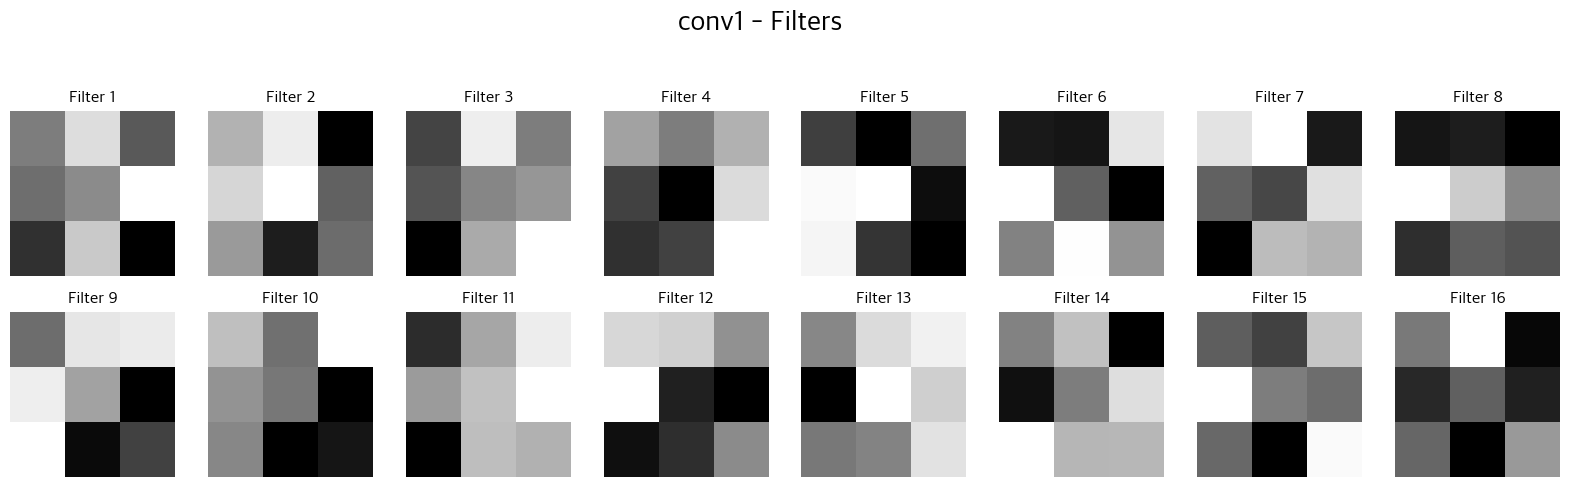

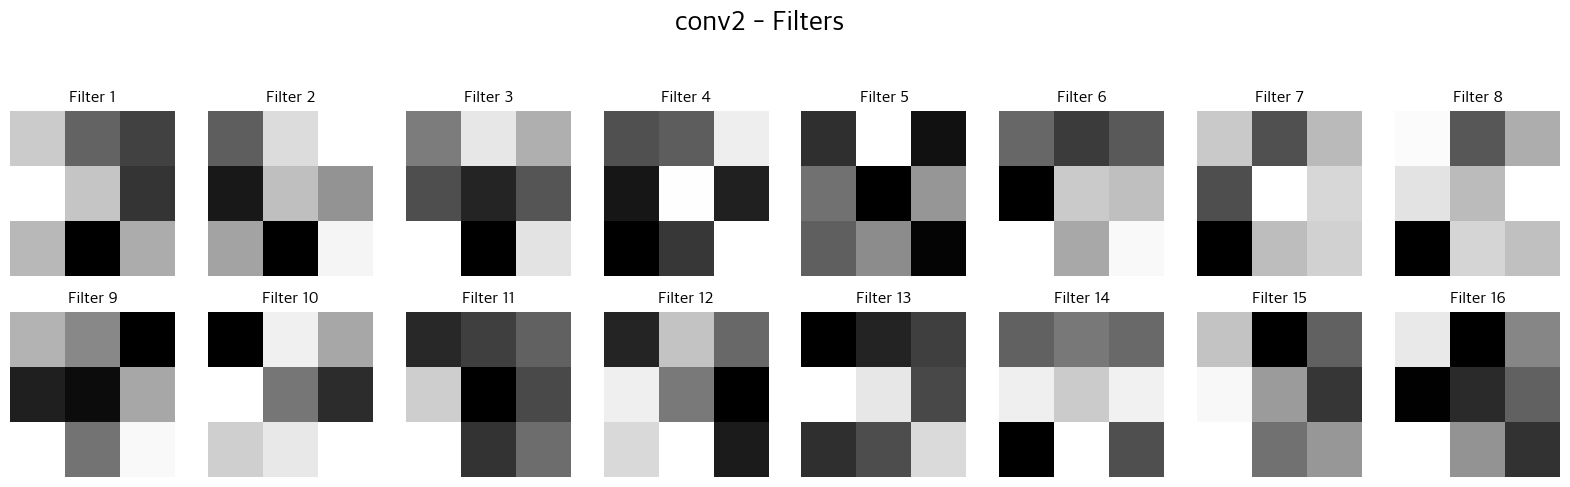

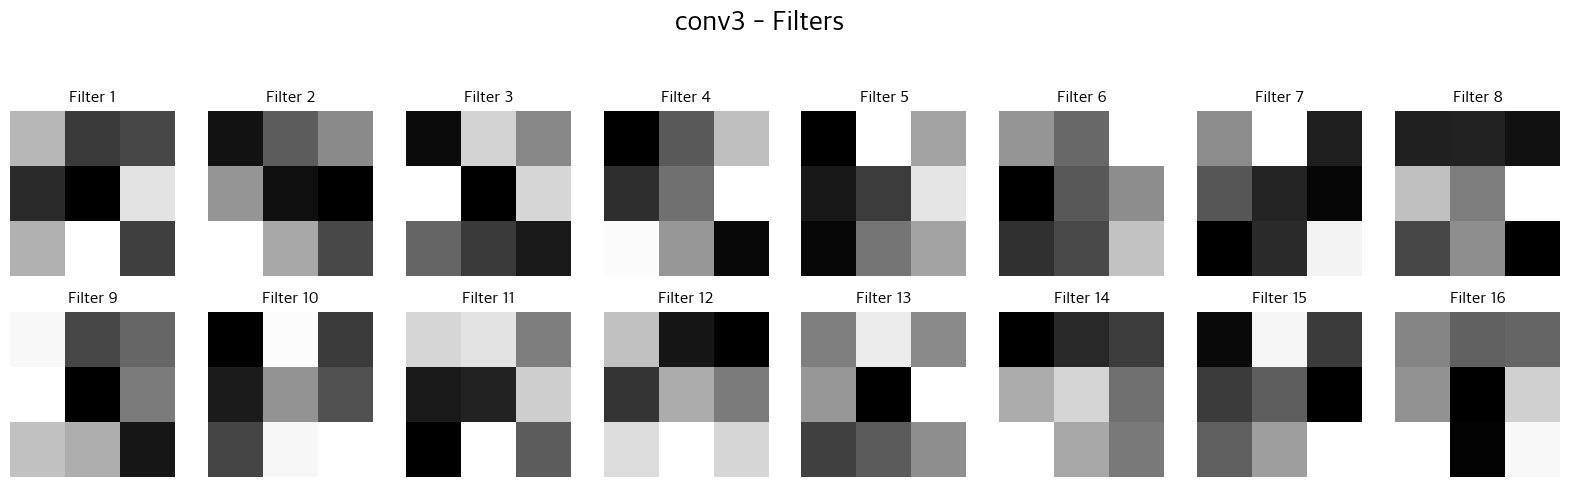

In [8]:
# ----------------------------- 합성곱 필터 시각화 -----------------------------
def visualize_conv_filters(model: nn.Module, layer_name: str, num_filters: int = 16):
    """
    지정된 합성곱 계층의 필터를 시각화합니다.

    Args:
        model (nn.Module): CNN 모델.
        layer_name (str): 시각화할 합성곱 계층의 이름.
        num_filters (int): 시각화할 필터의 수.
    """
    # 합성곱 계층 가져오기
    conv_layer = dict(model.named_modules())[layer_name]
    filters = conv_layer.weight.data.cpu().numpy()

    # 필터 수가 너무 많으면 일부만 시각화
    if num_filters > filters.shape[0]:
        num_filters = filters.shape[0]

    plt.figure(figsize=(20, 10))
    for i in range(num_filters):
        plt.subplot(4, 8, i + 1)
        plt.imshow(filters[i, 0, :, :], cmap='gray')
        plt.axis('off')
        plt.title(f'Filter {i+1}')
    plt.suptitle(f'{layer_name} - Filters', fontsize=20)
    plt.show()

# 합성곱 계층 이름 목록
conv_layers = ['conv1', 'conv2', 'conv3']

for layer in conv_layers:
    visualize_conv_filters(model, layer, num_filters=16)


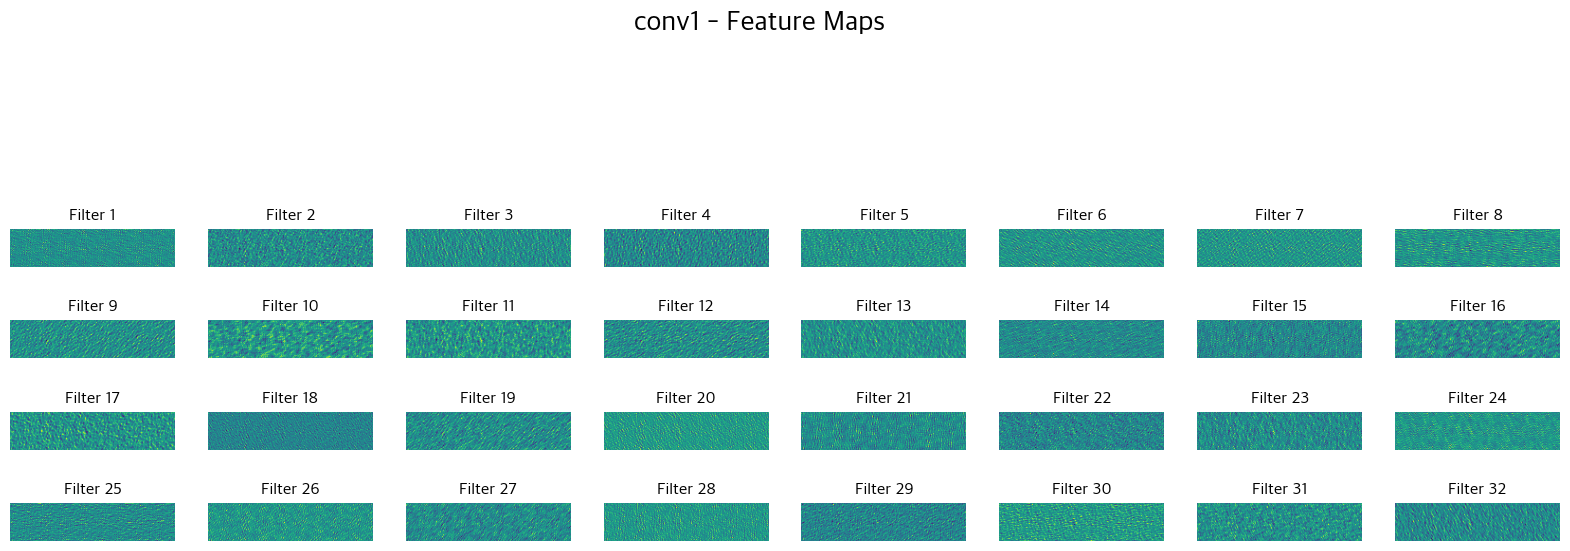

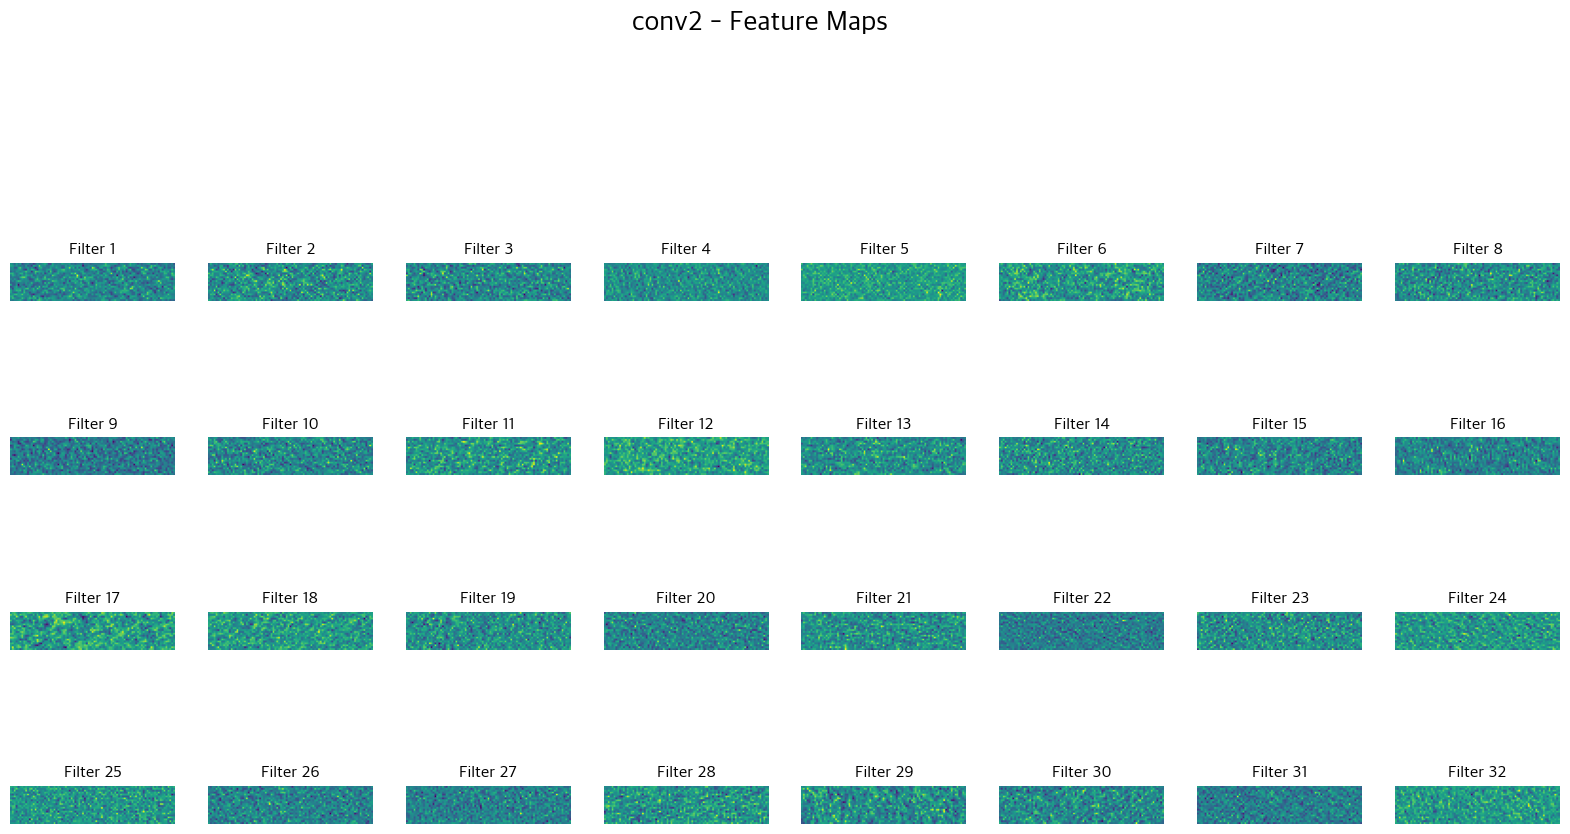

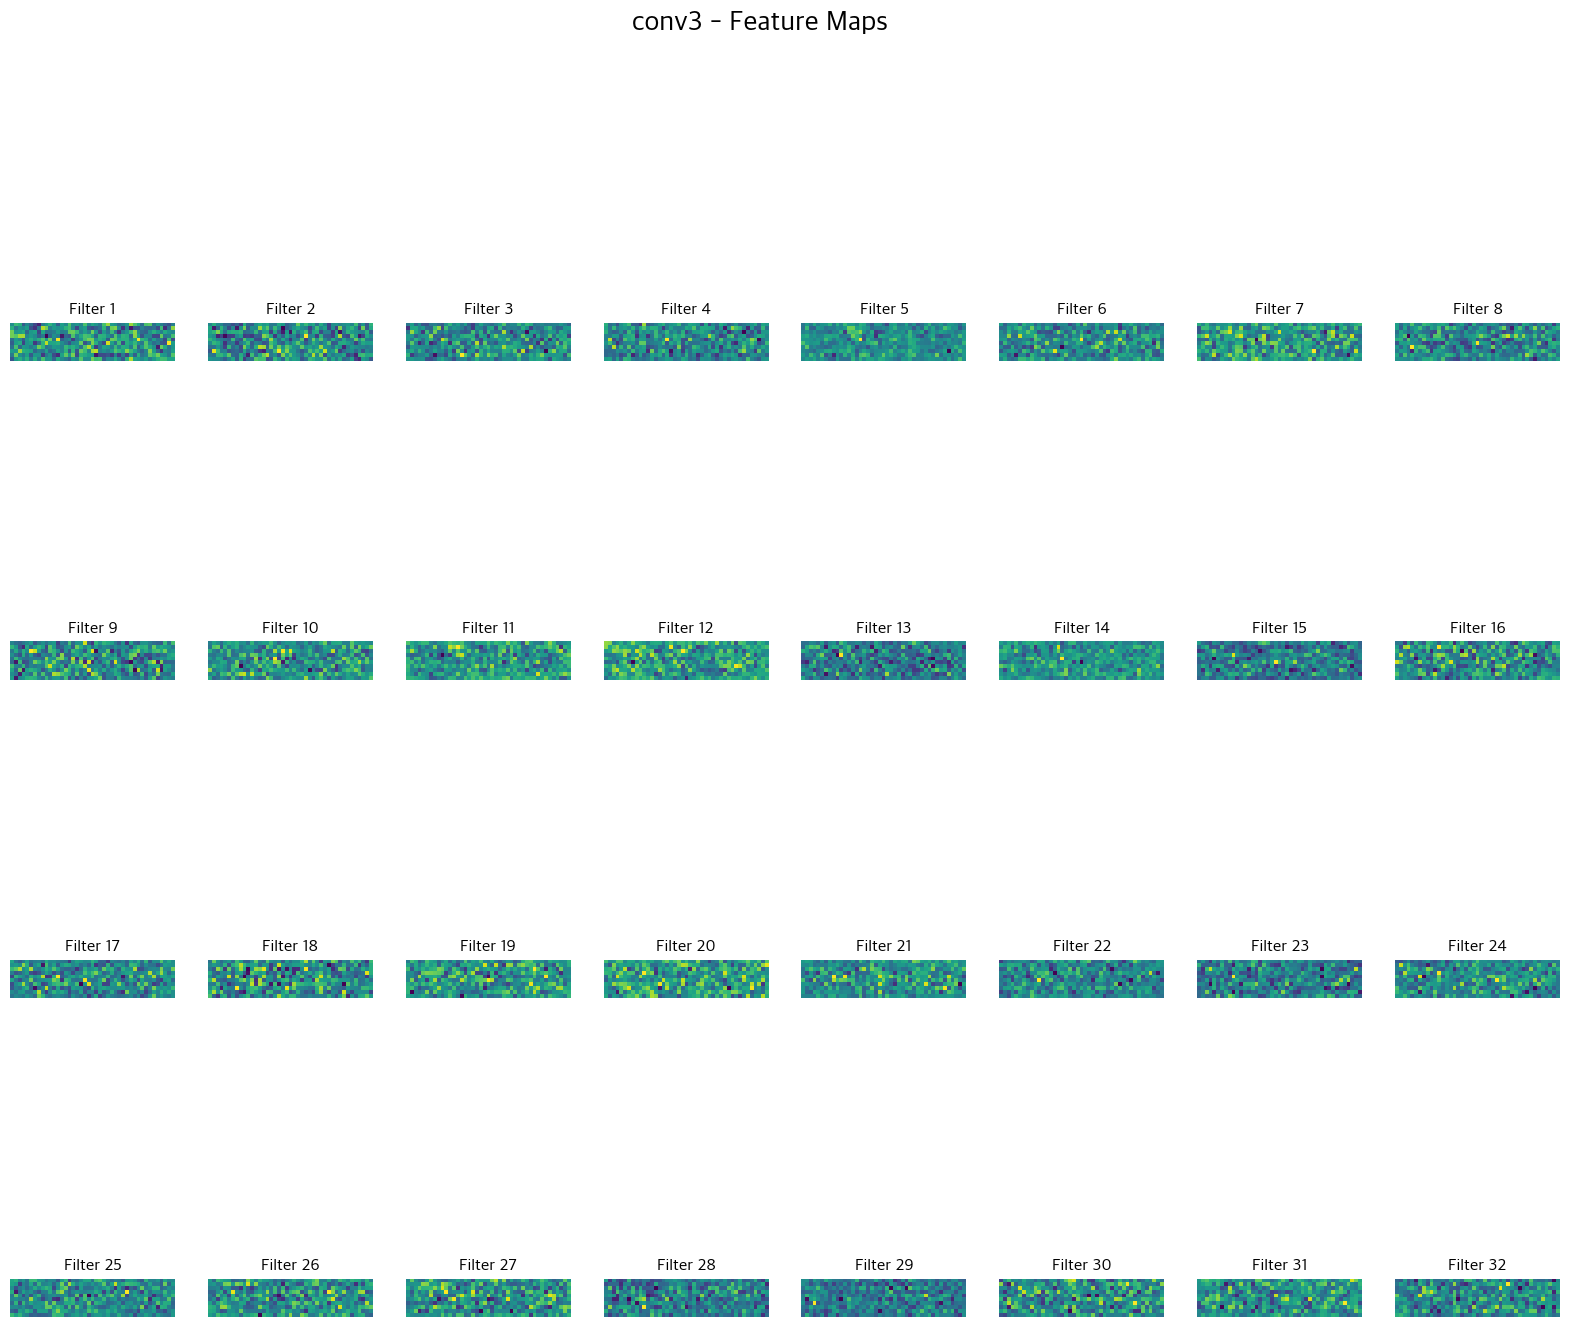

In [11]:
# ----------------------------- 특징 맵(Feature Maps) 시각화 -----------------------------
def visualize_feature_maps(model: nn.Module, layer_name: str, input_tensor: torch.Tensor):
    """
    지정된 합성곱 계층의 특징 맵을 시각화합니다.

    Args:
        model (nn.Module): CNN 모델.
        layer_name (str): 시각화할 합성곱 계층의 이름.
        input_tensor (torch.Tensor): 입력 텐서.
    """
    activation = {}
    
    def get_activation(name):
        def hook(model, input, output):
            activation[name] = output.detach()
        return hook

    # 지정된 계층에 후크(hook) 등록
    hook_handle = dict(model.named_modules())[layer_name].register_forward_hook(get_activation(layer_name))
    
    # 모델을 통과시켜 활성화 맵 수집
    with torch.no_grad():
        model(input_tensor)
    
    # 후크 제거
    hook_handle.remove()
    
    # 활성화 맵 가져오기
    act = activation[layer_name].squeeze().cpu().numpy()

    num_feature_maps = act.shape[0]
    num_cols = 8
    num_rows = num_feature_maps // num_cols + 1

    plt.figure(figsize=(20, 20))
    for i in range(min(num_feature_maps, 32)):  # 최대 32개 필터 시각화
        plt.subplot(num_rows, num_cols, i + 1)
        plt.imshow(act[i, :, :], cmap='viridis')
        plt.axis('off')
        plt.title(f'Filter {i+1}')
    plt.suptitle(f'{layer_name} - Feature Maps', fontsize=20)
    plt.show()

# 샘플 입력 데이터 생성
sample_input = torch.randn(1, 1, 40, 174).to("cpu")

# 모델을 통과시켜 특징 맵 시각화
feature_layers = ['conv1', 'conv2', 'conv3']

for layer in feature_layers:
    visualize_feature_maps(model, layer, sample_input)
